In [1]:
import time
import math
import copy
import torch
import pickle
import random
import logging
import warnings
import datetime
import pandas as pd
import numpy as np
from copy import deepcopy
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from imblearn.under_sampling import RandomUnderSampler
import fairlearn.datasets
from tqdm import tqdm
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from torch.autograd import grad
from torch.autograd.functional import vhp
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import mean_absolute_error, log_loss, r2_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, classification_report
from scipy.stats import spearmanr
from folktables import ACSDataSource, ACSIncome, ACSPublicCoverage

import scienceplots
warnings.filterwarnings("ignore")

E = math.e

In [2]:
ds = ACSDataSource(survey_year='2018', horizon='5-Year', survey='person')
STATE_DATA = ds.get_data(states=["AR"], download=True)

### Utility Functions

In [3]:
from matplotlib.ticker import FormatStrFormatter

In [4]:
def visualize_result(e_k_actual, e_k_estimated, ep, k_):
    plt.rcParams['figure.dpi'] = 300
    plt.style.use(['science'])
#     plt.rcParams.update({'font.size': 5})
    colors = cm.cool(np.linspace(0, 1, len(e_k_estimated)))
#     e_k_estimated = [-1*ek for ek in e_k_estimated]
    fig, ax = plt.subplots()
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    
    min_x = np.min(e_k_actual)
    max_x = np.max(e_k_actual)
    min_y = np.min(e_k_estimated)
    max_y = np.max(e_k_estimated)
    
# #     plt.rcParams['figure.figsize'] = 15, 15
    z = np.polyfit(e_k_actual,  e_k_estimated, 1)
    p = np.poly1d(z)
    xx = np.linspace(-p(2)/p(1), max(e_k_actual)+.0001)
    yy = np.polyval(p, xx)
    #add trendline to plot
    ax.plot(xx, yy, ls="-", color='k')
    
    for k in range(len(e_k_actual)):
        ax.scatter(e_k_actual[k], e_k_estimated[k], zorder=2, s=15, color=colors[k])

    ax.set_title(f'Actual vs. Estimated loss for k={k_:.2f}%', fontsize=8)
    ax.set_xlabel('Actual loss difference', fontsize=8)
    ax.set_ylabel('Estimated loss difference', fontsize=8)
   
    ax.set_xlim(min_x-.0001, max_x+.0001)
    ax.set_ylim(min_y-.0001, max_y+.0001)
    
#     #label_locations = np.arange(5)  
#     #width = 0.25 
    
#     xlabels = np.linspace(min_x-.0001, max_x+.0001, 6)
#     ylabels = np.linspace(min_y-.0001, max_y+.0001, 6)
    
    text = 'MAE = {:.03}\nP = {:.03}'.format(mean_absolute_error(e_k_actual, e_k_estimated), spearmanr(e_k_actual, e_k_estimated).correlation)
#     ax.text(max_x+.00001,min_y-.00008, text, verticalalignment='bottom', horizontalalignment='right', fontsize=8)
# #     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# #     plt.tight_layout()
    plt.xticks(rotation = 45, fontsize=7, visible=True)
    plt.yticks(fontsize=7)
    print(text)
    plt.show()
    # cooler color = smaller epsilon

In [5]:
 class CreateData(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.targets[idx]

        return out_data, out_label

In [6]:
def get_data_group(dfTrain, feature_set, label, k):    

#     selected_group = dfTrain.loc[dfTrain['SEX'] == 0]

    num_to_sample = int((k/100)*len(dfTrain))

    sampled_group = dfTrain.sample(n=num_to_sample, ignore_index=False)
    not_selected = dfTrain.drop(sampled_group.index)

    selected_group_X = sampled_group[feature_set]
    selected_group_y = sampled_group[label]

    not_selected_group_X = not_selected[feature_set]
    not_selected_group_y = not_selected[label]   
    
    return selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y


In [7]:
def get_acspubcov(data):
    features, labels, _ = ACSPublicCoverage.df_to_pandas(data)
    
    df = pd.concat([features, labels], axis=1)
    
    df = df.drop_duplicates(keep='first', ignore_index=True)
    df = df.drop(['ANC', 'ST', 'SCHL', 'ESP', 'FER', 'MIG', 'DEAR', 'DEYE', 'DREM'], axis=1)
    
    column_names = ['AGEP', 'MAR', 'SEX', 'DIS', 'CIT', 'PINCP', 'ESR', 'RAC1P', 'MIL', 'NATIVITY']
    
    def numericalBinary(dataset, features):
        dataset[features] = np.where(dataset[features] >= dataset[features].mean(), 1, 0)

    def binarize(dataset, features):
        dataset[features] = np.where(df[features] == 1, 1, 0)
            
    numericalBinary(df,['AGEP', 'PINCP'])
    binarize(df, ['MAR', 'SEX', 'DIS', 'RAC1P', 'PUBCOV', 'NATIVITY'])
    
    #df['ESP'] = np.where((df['ESP'] == 1) | (df['ESP'] == 2) | (df['ESP'] == 3) | (df['ESP'] == 4), 1, 0)
    df['CIT'] = np.where((df['CIT'] == 1) | (df['CIT'] == 3), 1, 0)
    df['MIL'] = np.where((df['MIL'] == 1) | (df['MIL'] == 2) | (df['MIL'] == 3), 1, 0)
    df['ESR'] = np.where((df['ESR'] == 1) | (df['ESR'] == 2) | (df['ESR'] == 4) | (df['ESR'] == 5), 1, 0)
    
#     to_replace = ['workclass', 'education-num', 'marital-status', 'occupation','relationship', 'native-country']
#     dfTrain = pd.get_dummies(dfTrain, columns=to_replace, drop_first = False)
    
    num_train = int(len(df) * .8)
    dfTrain = df.sample(n=num_train, replace=False, axis=0, ignore_index=False)

    dfTest = df.drop(dfTrain.index, axis=0)
    
    label = 'PUBCOV'
    return dfTrain, dfTest, label

In [8]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

### Randomized Response

In [9]:
def get_p(epsilon):
    p = float(E ** epsilon) / float(1 + (E ** epsilon))
    q = 1-p
    
    return p, q

### Models

In [10]:
class LogReg(torch.nn.Module):
    def __init__(self, num_features, scikit_model):
        super(LogReg, self).__init__()
        
        self.fc1 = torch.nn.Linear(num_features, 1, bias=False)
        self.criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
        
        weights = torch.from_numpy(scikit_model.coef_).type(torch.float32)
        biases = torch.from_numpy(np.array(scikit_model.intercept_)).type(torch.float32)

        with torch.no_grad():
            self.fc1.weight = nn.Parameter(weights)
            self.fc1.bias = nn.Parameter(biases)

    def forward(self, x):
        logits = self.fc1(x)

        return logits

### Influence Calculation Functions


In [11]:
def calc_influence_single(scikit_model, epsilon, train_data, test_data, group_data, device, num_features, criterion):
        
    torch_model = LogReg(num_features, scikit_model)
    torch_model.to(device)
    
    start = time.time()
    est_hess = explicit_hess(torch_model, train_data, device, criterion)
    
    grad_test = grad_z([test_data[0], test_data[1]], torch_model, device, criterion)
 
    s_test_vec = torch.mm(grad_test[0], est_hess.to(device))

    p, q = get_p(epsilon)   
    
    grad_z_vec = grad_training([group_data[0], group_data[1]], torch_model, device, epsilon)
   
    influence = torch.dot(s_test_vec.flatten(), grad_z_vec[0].flatten()) * (1/len(train_data[0]))
    end = time.time() - start
    
    return influence.cpu().detach().numpy(), end

In [12]:
def explicit_hess(model, train_data, device, criterion):

    logits = model(train_data[0])
    loss = criterion(logits.ravel(), train_data[1]) #reduction mean

    grads = grad(loss, model.parameters(), retain_graph=True, create_graph=True)

    hess_params = torch.zeros(len(model.fc1.weight[0]), len(model.fc1.weight[0]))
    
    for i in range(len(model.fc1.weight[0])):
        hess_params_ = grad(grads[0][0][i], model.parameters(), retain_graph=True)[0][0]
        for j, hp in enumerate(hess_params_):
            hess_params[i,j] = hp

    inv_hess = torch.linalg.inv(hess_params)
    return inv_hess

In [13]:
def grad_z(test_data, model, device, criterion):

    model.eval()

    logits = model(test_data[0])
    loss = criterion(logits.ravel(), test_data[1]) # reduction mean
    
    return grad(loss, model.parameters())

In [14]:
def grad_training(group_data, model, device, epsilon):
    
    epsilon = epsilon/3
    criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
    
    model.eval()

    col_names = ['MAR', 'SEX']#, 'DIS', 'RAC1P', 'AGEP']
    
    cartesian =[[0,0,0],
                [0,0,1],
                [0,1,0],
                [0,1,1],
                [1,0,0],
                [1,0,1],
                [1,1,0],
                [1,1,1]]
    
    agg_loss = 0
    for index, row in group_data[0].iterrows():
        record_agg = 0
        pert_data = row.copy()
        
        label = torch.FloatTensor([group_data[1].at[index]]).to(device)
        
        orig_logits = model(torch.FloatTensor(row.values).to(device))
        orig_loss = criterion(orig_logits, label.ravel())
        
        original_combo = str(row['MAR']) + str(row['SEX']) + str(group_data[1].at[index])
        for i, combo in enumerate(cartesian):
            str_combo = ''.join(str(c) for c in combo)
            if str_combo != original_combo:
                for c, col in enumerate(col_names):
                    pert_data.at[col] = cartesian[i][c]
                pert_label = torch.FloatTensor([cartesian[i][2]]).to(device)
                    
                pert_logits = model(torch.FloatTensor(pert_data.values).to(device))
                pert_loss = criterion(pert_logits, pert_label)

                record_agg += (pert_loss - orig_loss)
        agg_loss += record_agg
        
    loss = (1-(float((E ** epsilon)/(1 + (E ** epsilon)))**3))*(agg_loss)
    
    to_return = grad(loss, model.parameters())
    
    return to_return

### Main Function

In [15]:
def Main(dataset, epsilons, ks, num_rounds):

    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
    
    all_orig_loss_e_k = []
    all_est_loss_e_k = []
    all_time = []
    
    for nr in range(num_rounds):
        print(f'\nRound {nr+1}')
        ############
        # Get data #
        ############
        print('\nGetting Data...')
        
        dfTrain, dfTest, label = get_acspubcov(STATE_DATA)

        feature_set = list(set(dfTrain.columns) - {label})
        num_features = len(feature_set)

        X_train, X_test = dfTrain[feature_set].values, dfTest[feature_set].values
        y_train, y_test = dfTrain[label].values, dfTest[label].values
    
        x_test_input = torch.FloatTensor(X_test).to(device)
        y_test_input = torch.FloatTensor(y_test).to(device)

        x_train_input = torch.FloatTensor(X_train).to(device)
        y_train_input = torch.FloatTensor(y_train).to(device)
   
        ##############################################
        # Train original model and get original loss #
        ##############################################
        print('Training original model...')
        LR = SGDClassifier(loss='log_loss', penalty='None', eta0=0.01, fit_intercept=False, learning_rate='constant')
        LR.fit(X_train, y_train)
        
        model_to_send = deepcopy(LR)
        
        predictions = LR.predict_proba(X_test)
        label_predictions = [np.argmax(p) for p in predictions]
      
        acc_ori = accuracy_score(y_test, label_predictions)
        test_loss_ori = log_loss(y_test, predictions, eps=1e-15, labels=[0,1])
        
        e_k_act_losses = []
        e_k_est_losses = []
        influence_time = []
        
        ################################################################
        # Perform influence and retraining for all epsilons a k values #
        ################################################################
        print('\nBegining epsilon and k rounds')
        print('-----------------------------')
        for ep in epsilons:
            print(f'\nEpsilon: {ep}')
            
            k_act_losses = []
            k_est_losses = []
            inf_time = []
            
            for k in ks:
                # Influence
                print(f'k: {k:.2f}')
                selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y = get_data_group(dfTrain, feature_set, label, k)
                loss_diff_approx, tot_time = calc_influence_single(model_to_send, ep, [x_train_input, y_train_input], [x_test_input, y_test_input], [selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y], device, num_features, criterion)
                print(f'Approx difference: {loss_diff_approx:.5f}')
              
                ###########
                # Retrain #
                ###########
                
                p, q = get_p(ep/3)
                
                selected_group_x_copy = selected_group_X
                selected_group_y_copy = selected_group_y
                
                for index, row in selected_group_X.iterrows():
                    rnd_1 = np.random.random()
                    rnd_2 = np.random.random()
                    rnd_3 = np.random.random()
#      
                    if rnd_1 > p:
                        selected_group_x_copy.at[index, 'MAR'] = 1 - row['MAR']
                    if rnd_2 > p:
                        selected_group_x_copy.at[index, 'SEX'] = 1 - row['SEX']
                    if rnd_3 > p:
                        selected_group_y_copy.at[index] = 1 - selected_group_y.at[index]
                        
                y_w_pert = pd.concat([not_selected_group_y, selected_group_y_copy], axis = 0, ignore_index=True)
                x_w_pert = pd.concat([not_selected_group_X, selected_group_x_copy], axis = 0, ignore_index=True)

                pert_LR = SGDClassifier(loss='log_loss', penalty='None', eta0=0.01, fit_intercept=False, learning_rate='constant')
                pert_LR.fit(x_w_pert, y_w_pert)
                pert_param = LR.coef_

                pert_predictions = pert_LR.predict_proba(X_test)
                pert_label_predictions = [np.argmax(p) for p in pert_predictions]

                acc_pert = accuracy_score(y_test, pert_label_predictions)
                test_loss_retrain = log_loss(y_test, pert_predictions, eps=1e-15, labels=[0,1])

                 # get true loss diff
                loss_diff_true = test_loss_retrain - test_loss_ori
                print(f'True difference: {loss_diff_true:.5f}')
                k_act_losses.append(loss_diff_true)
                k_est_losses.append(loss_diff_approx)
                inf_time.append(tot_time)
            
            e_k_act_losses.append(k_act_losses)
            e_k_est_losses.append(k_est_losses)
            influence_time.append(inf_time)
            
        all_orig_loss_e_k.append(e_k_act_losses)
        all_est_loss_e_k.append(e_k_est_losses) 
        all_time.append(influence_time)
    
    return all_orig_loss_e_k, all_est_loss_e_k, all_time

### Perform Experiment 

#### Constants

In [16]:
epsilons = np.linspace(.001, 5, 30) #30
k = np.linspace(75, 75, 1) #10
rounds = 10

In [17]:
all_orig_loss_e_k, all_est_loss_e_k, all_time = Main('adult', epsilons, k, rounds)

with open('all_orig_loss_e_k_adult_full_k.txt', "wb") as file:   #Pickling
    pickle.dump(all_orig_loss_e_k, file)

with open('all_est_loss_e_k_adult_full_k.txt', "wb") as file2:   #Pickling
    pickle.dump(all_est_loss_e_k, file2)


Round 1

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

Epsilon: 0.001
k: 75.00
Approx difference: -0.04128
True difference: 0.08262

Epsilon: 0.17337931034482756
k: 75.00
Approx difference: -0.04036
True difference: 0.10710

Epsilon: 0.3457586206896551
k: 75.00
Approx difference: -0.04116
True difference: 0.06413

Epsilon: 0.5181379310344827
k: 75.00
Approx difference: -0.04001
True difference: 0.05542

Epsilon: 0.6905172413793103
k: 75.00
Approx difference: -0.04066
True difference: 0.07412

Epsilon: 0.8628965517241378
k: 75.00
Approx difference: -0.04101
True difference: 0.07430

Epsilon: 1.0352758620689653
k: 75.00
Approx difference: -0.03830
True difference: 0.07146

Epsilon: 1.207655172413793
k: 75.00
Approx difference: -0.03810
True difference: 0.06553

Epsilon: 1.3800344827586204
k: 75.00
Approx difference: -0.03725
True difference: 0.08366

Epsilon: 1.5524137931034478
k: 75.00
Approx difference: -0.03632
True differenc

Approx difference: 0.02729
True difference: 0.02284

Epsilon: 5.0
k: 75.00
Approx difference: 0.02732
True difference: 0.01838

Round 4

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

Epsilon: 0.001
k: 75.00
Approx difference: -0.06930
True difference: 0.07231

Epsilon: 0.17337931034482756
k: 75.00
Approx difference: -0.07013
True difference: 0.05819

Epsilon: 0.3457586206896551
k: 75.00
Approx difference: -0.06802
True difference: 0.06144

Epsilon: 0.5181379310344827
k: 75.00
Approx difference: -0.06444
True difference: 0.06838

Epsilon: 0.6905172413793103
k: 75.00
Approx difference: -0.06651
True difference: 0.05681

Epsilon: 0.8628965517241378
k: 75.00
Approx difference: -0.06628
True difference: 0.06113

Epsilon: 1.0352758620689653
k: 75.00
Approx difference: -0.06437
True difference: 0.05873

Epsilon: 1.207655172413793
k: 75.00
Approx difference: -0.06252
True difference: 0.05009

Epsilon: 1.3800344827586204
k: 75.00
Approx

True difference: 0.01644

Epsilon: 4.655241379310344
k: 75.00
Approx difference: 0.03837
True difference: 0.02352

Epsilon: 4.8276206896551725
k: 75.00
Approx difference: 0.03776
True difference: 0.01997

Epsilon: 5.0
k: 75.00
Approx difference: 0.03677
True difference: 0.01251

Round 7

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

Epsilon: 0.001
k: 75.00
Approx difference: 0.01876
True difference: 0.09232

Epsilon: 0.17337931034482756
k: 75.00
Approx difference: 0.01744
True difference: 0.07189

Epsilon: 0.3457586206896551
k: 75.00
Approx difference: 0.01668
True difference: 0.07131

Epsilon: 0.5181379310344827
k: 75.00
Approx difference: 0.01750
True difference: 0.06447

Epsilon: 0.6905172413793103
k: 75.00
Approx difference: 0.01652
True difference: 0.05663

Epsilon: 0.8628965517241378
k: 75.00
Approx difference: 0.01634
True difference: 0.04776

Epsilon: 1.0352758620689653
k: 75.00
Approx difference: 0.01694
True differenc

True difference: 0.01546

Epsilon: 4.310482758620689
k: 75.00
Approx difference: -0.02977
True difference: 0.01525

Epsilon: 4.482862068965517
k: 75.00
Approx difference: -0.02951
True difference: 0.01343

Epsilon: 4.655241379310344
k: 75.00
Approx difference: -0.02776
True difference: 0.02497

Epsilon: 4.8276206896551725
k: 75.00
Approx difference: -0.02640
True difference: 0.00834

Epsilon: 5.0
k: 75.00
Approx difference: -0.02592
True difference: 0.01562

Round 10

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

Epsilon: 0.001
k: 75.00
Approx difference: 0.04172
True difference: 0.09128

Epsilon: 0.17337931034482756
k: 75.00
Approx difference: 0.04229
True difference: 0.08919

Epsilon: 0.3457586206896551
k: 75.00
Approx difference: 0.04095
True difference: 0.06258

Epsilon: 0.5181379310344827
k: 75.00
Approx difference: 0.04167
True difference: 0.05747

Epsilon: 0.6905172413793103
k: 75.00
Approx difference: 0.04037
True diffe

In [18]:
with open('all_orig_loss_e_k_adult_full_k.txt', 'rb') as f:
    all_orig_loss_e_k = pickle.load(f)
    
with open('all_est_loss_e_k_adult_full_k.txt', 'rb') as f:
    all_est_loss_e_k = pickle.load(f)

In [19]:
print(len(all_orig_loss_e_k[0]))

30


In [20]:
# [actual, estimate]

sum_orig_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_est_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_time = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]

avg_orig_loss = []
avg_est_loss = []
avg_time = []

for round_ in range(len(all_orig_loss_e_k)):
    for e in range(len(epsilons)):
        for k_ in range(len(k)):
            sum_orig_loss_e_k[e][k_] = sum_orig_loss_e_k[e][k_] + all_orig_loss_e_k[round_][e][k_]
            sum_est_loss_e_k[e][k_] = sum_est_loss_e_k[e][k_] + all_est_loss_e_k[round_][e][k_]
            

for e in range(len(epsilons)):
    avg_orig_loss.append([ elem / len(all_orig_loss_e_k) for elem in sum_orig_loss_e_k[e]])
    avg_est_loss.append([elem/ len(all_orig_loss_e_k) for elem in sum_est_loss_e_k[e]])

k_e_orig = [[] for _ in range(len(k))]
k_e_est = [[] for _ in range(len(k))]

for e in range(len(epsilons)):
    for k_ in range(len(k)):
        k_e_orig[k_].append(avg_orig_loss[e][k_])
        k_e_est[k_].append(avg_est_loss[e][k_])


MAE = 0.0407
P = 0.859


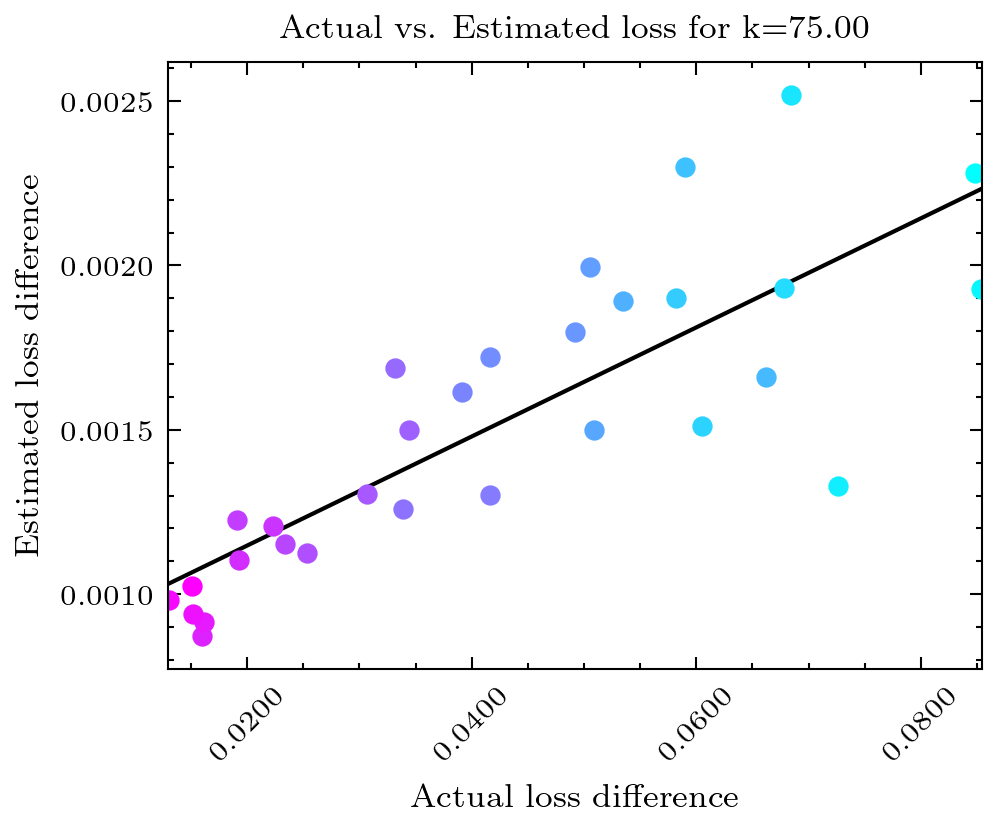

In [21]:
for i in range(len(k_e_orig)):
    visualize_result(k_e_orig[i], k_e_est[i], epsilons, k[i])